In [1]:
import os
import io
import time
import traceback
import h5py
import tqdm
import copy

import pandas as pd
import numpy as np
from collections import defaultdict
from tifffile import imread, imwrite
from skimage.metrics import normalized_root_mse, peak_signal_noise_ratio, structural_similarity
from math import isinf, isnan, sqrt
import hdf5plugin
import matplotlib.pyplot as plt
import matplotlib.collections as clt
import matplotlib
from matplotlib.offsetbox import AnchoredText
from matplotlib_scalebar.scalebar import ScaleBar
import random
import tqdm
import matplotlib.patches as patches
import glob
import numpy as np
from tifffile import imread, imwrite

In [2]:
np.random.seed(1234)
random.seed(1234)

In [3]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 7
        }
padding = {
    'titlepad': 3,
    'labelpad': 1,
}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **padding)

In [4]:
data_path = '/data/duanb/'

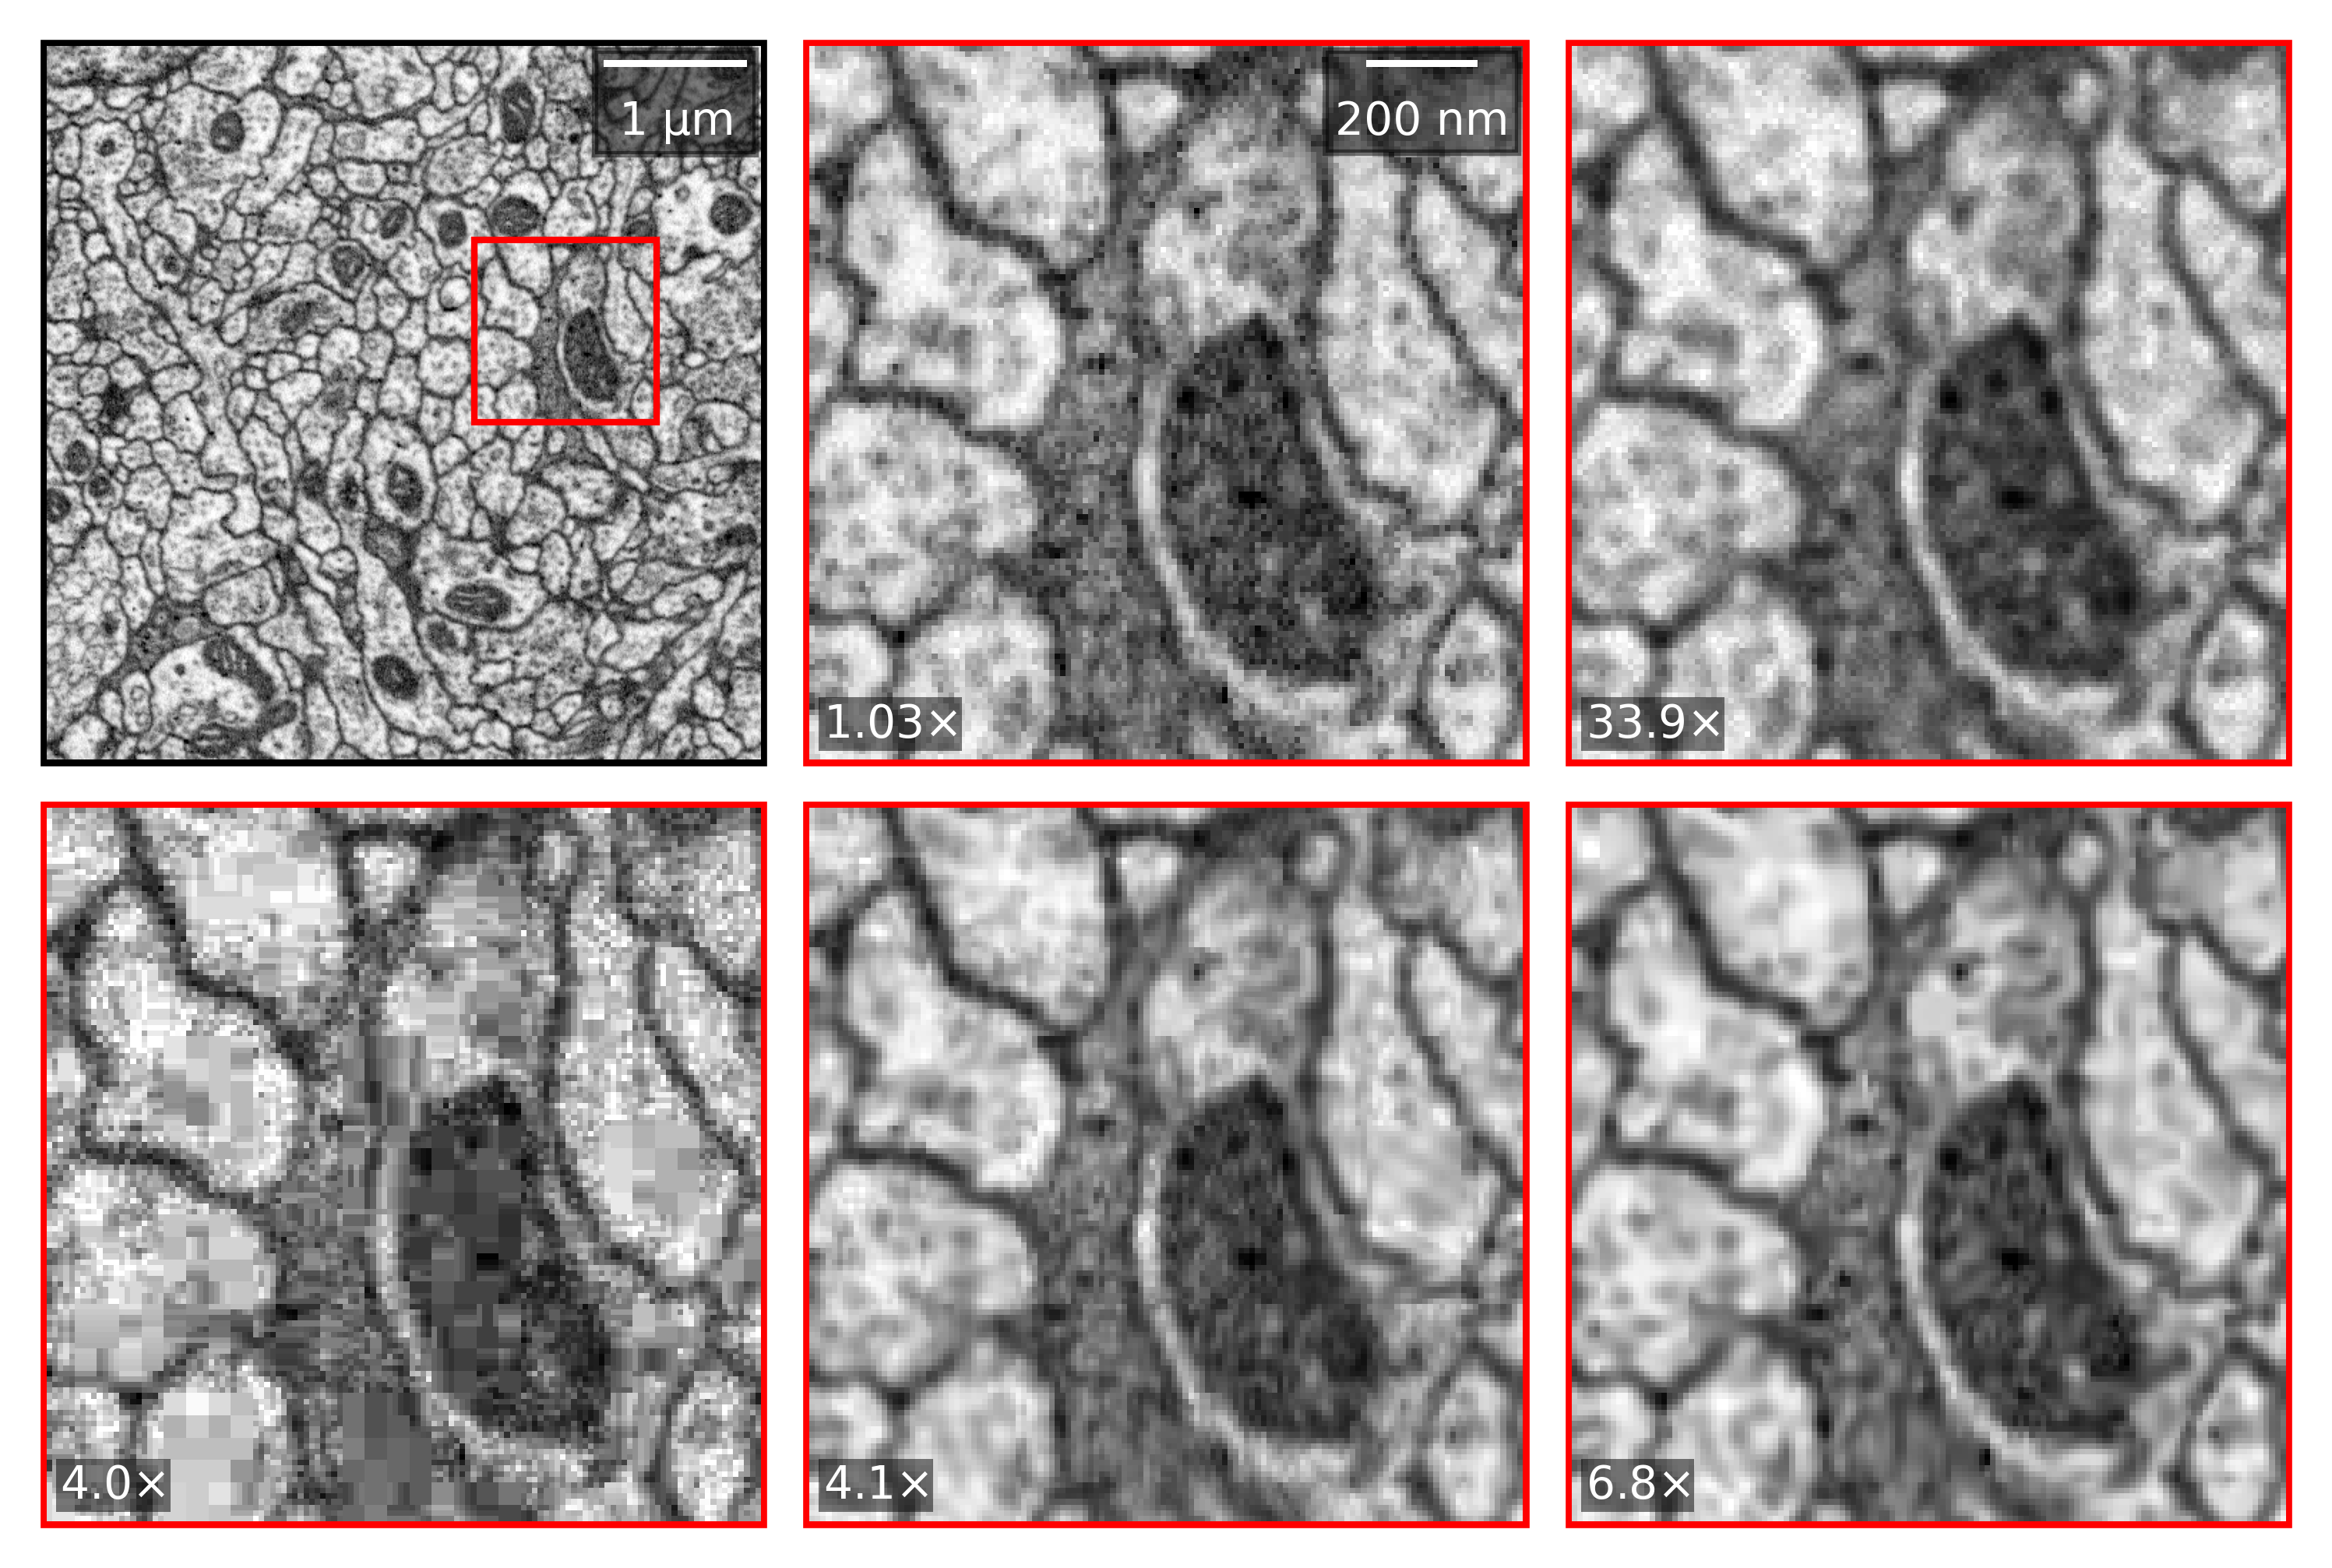

In [25]:
fig, axs = plt.subplots(figsize=(5, 3.4), dpi=600, ncols=3, nrows=2, layout='tight')

axs = axs.flat    

axs[0].imshow(imread(data_path + 'EM/image.tif')[100, ...], cmap='gray')
axs[1].imshow(imread('compression_big/thumbnail/EM_patch.tif'), cmap='gray')
# axs[2].imshow(imread('compression_big/thumbnail/EM_AV1_grain_high.tif'), cmap='gray')
axs[2].imshow(imread('FIB25/tmp/thumbnail/EM_AV1_grain50_Q45_cs34.tif'), cmap='gray')
axs[3].imshow(imread('compression_big/thumbnail/EM_X264_high.tif'), cmap='gray')
axs[4].imshow(imread('compression_big/thumbnail/EM_X265_high.tif'), cmap='gray')
axs[5].imshow(imread('compression_big/thumbnail/EM_AV1_high.tif'), cmap='gray')


for i in range(0, 6):
    ax = axs[i]
    if i == 0:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('k')
    else:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('r')
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

for i, ratio in zip(range(1, 6), [1.03, 33.9, 4.0, 4.1, 6.8]):
    ax = axs[i]
    if i == 1:
        at = AnchoredText(f'{ratio:.2f}$\\times$', borderpad=0.2, pad=0.1, prop=dict(size=7, color='w'), frameon=True, loc='lower left')
    else:
        at = AnchoredText(f'{ratio:.1f}$\\times$', borderpad=0.2, pad=0.1, prop=dict(size=7, color='w'), frameon=True, loc='lower left')
    at.patch.set_facecolor('k')
    at.patch.set_linewidth(0)
    at.patch.set_alpha(0.5)
    ax.add_artist(at)

axs[0].add_artist(ScaleBar(10, 'nm', location='upper right', box_color='k', box_alpha=0.5, color='w', width_fraction=0.01))
axs[0].add_patch(patches.Rectangle((299, 135), 128, 128, linewidth=1, edgecolor='r', facecolor='none'))
axs[1].add_artist(ScaleBar(10, 'nm', location='upper right', box_color='k', box_alpha=0.5, color='w', width_fraction=0.01))
plt.savefig('benchmark_part1.pdf', bbox_inches='tight')

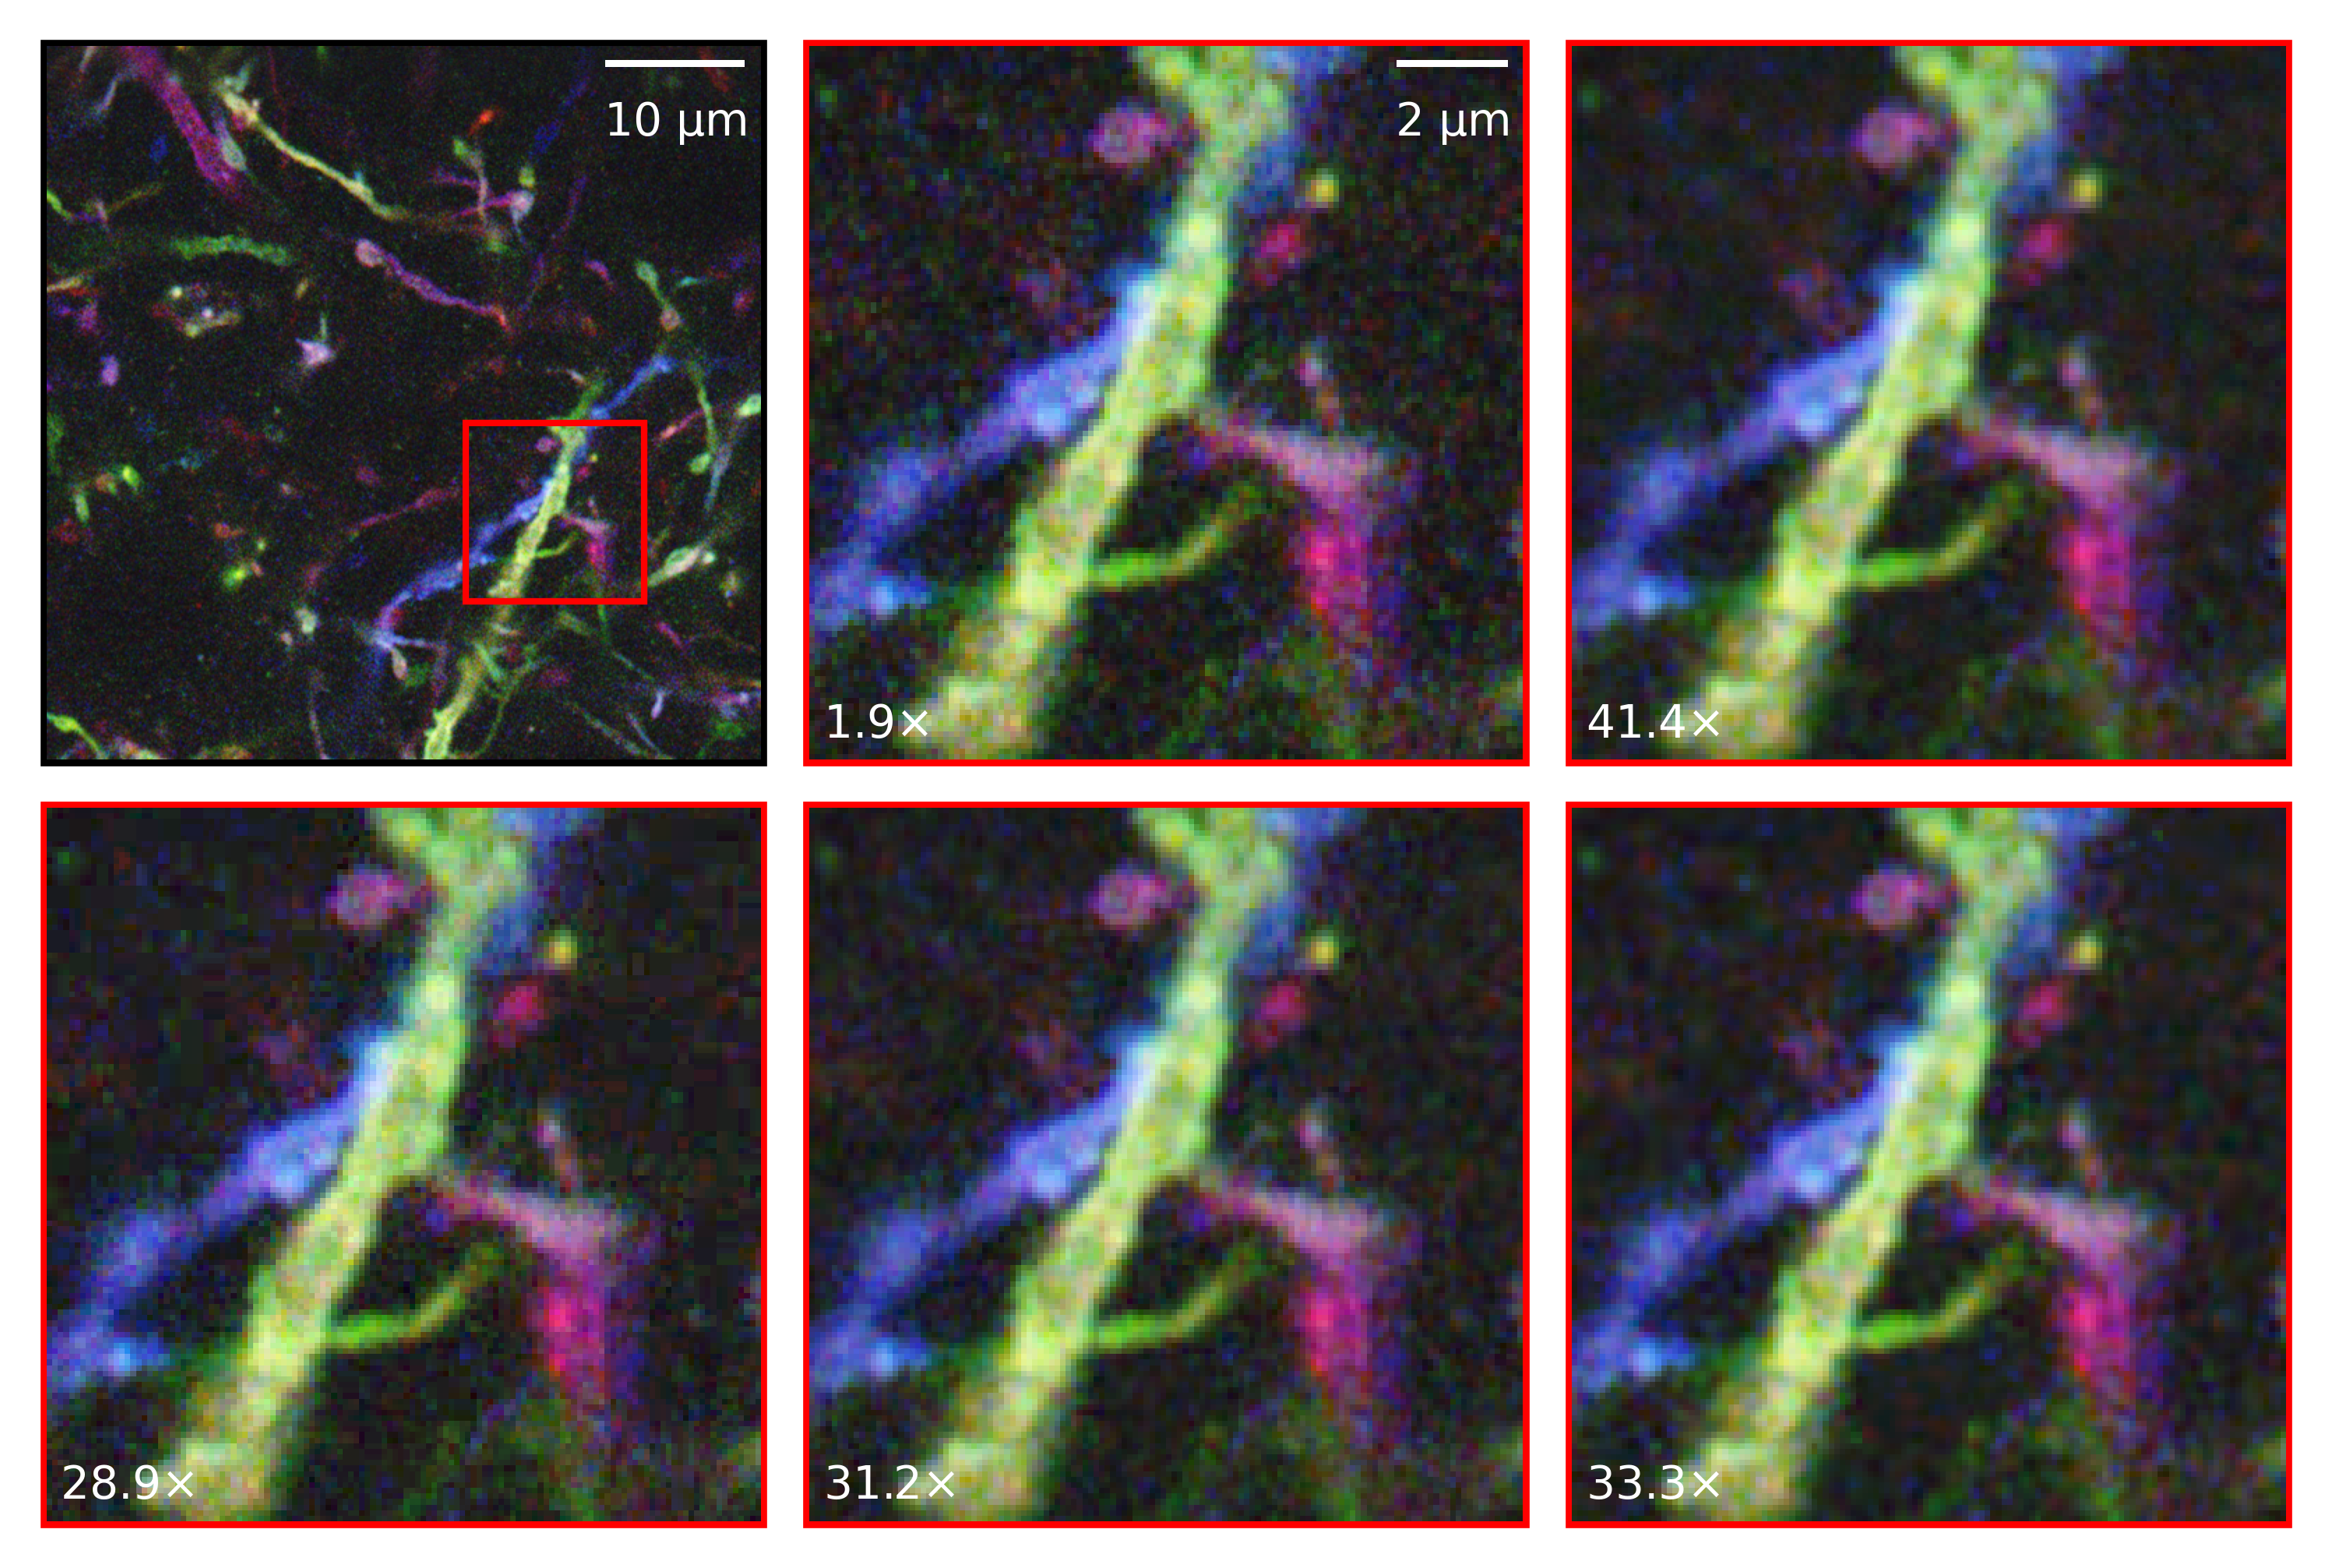

In [31]:
fig, axs = plt.subplots(figsize=(5, 3.4), dpi=600, ncols=3, nrows=2, layout='tight')

axs = axs.flat    

img = imread('/data/duanb/Brainbow/nTracer_sample.tif')
img = img * 1.0
img = np.transpose(img, [1, 0, 2, 3])
for i in range(4):
    img[i] /= img[i].max()
    img[i] = np.power(img[i], 0.5)
img = np.moveaxis(img, 0, -1)
img = img[11, ..., :3]
axs[0].imshow(img)
axs[1].imshow(imread('compression_big/thumbnail/Brainbow_patch.tif').transpose(1, 2, 0))
axs[2].imshow(imread('compression_big/thumbnail/Brainbow_AV1_grain_low.tif').transpose(1, 2, 0))
axs[3].imshow(imread('compression_big/thumbnail/Brainbow_X264_low.tif').transpose(1, 2, 0))
axs[4].imshow(imread('compression_big/thumbnail/Brainbow_X265_low.tif').transpose(1, 2, 0))
axs[5].imshow(imread('compression_big/thumbnail/Brainbow_AV1_low.tif').transpose(1, 2, 0))

for i in range(0, 6):
    ax = axs[i]
    if i == 0:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('k')
    else:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('r')
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

for i, ratio in zip(range(1, 6), [1.9, 41.4, 28.9, 31.2, 33.3]):
    ax = axs[i]
    at = AnchoredText(f'{ratio:.1f}$\\times$', borderpad=0.2, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
    ax.add_artist(at)
    
axs[0].add_artist(ScaleBar(0.1, 'um', location='upper right', frameon=False, color='w'))
axs[0].add_patch(patches.Rectangle((300, 270), 128, 128, linewidth=1, edgecolor='r', facecolor='none'))
axs[1].add_artist(ScaleBar(0.1, 'um', location='upper right', frameon=False, color='w'))
plt.savefig('benchmark_part2.pdf', bbox_inches='tight')

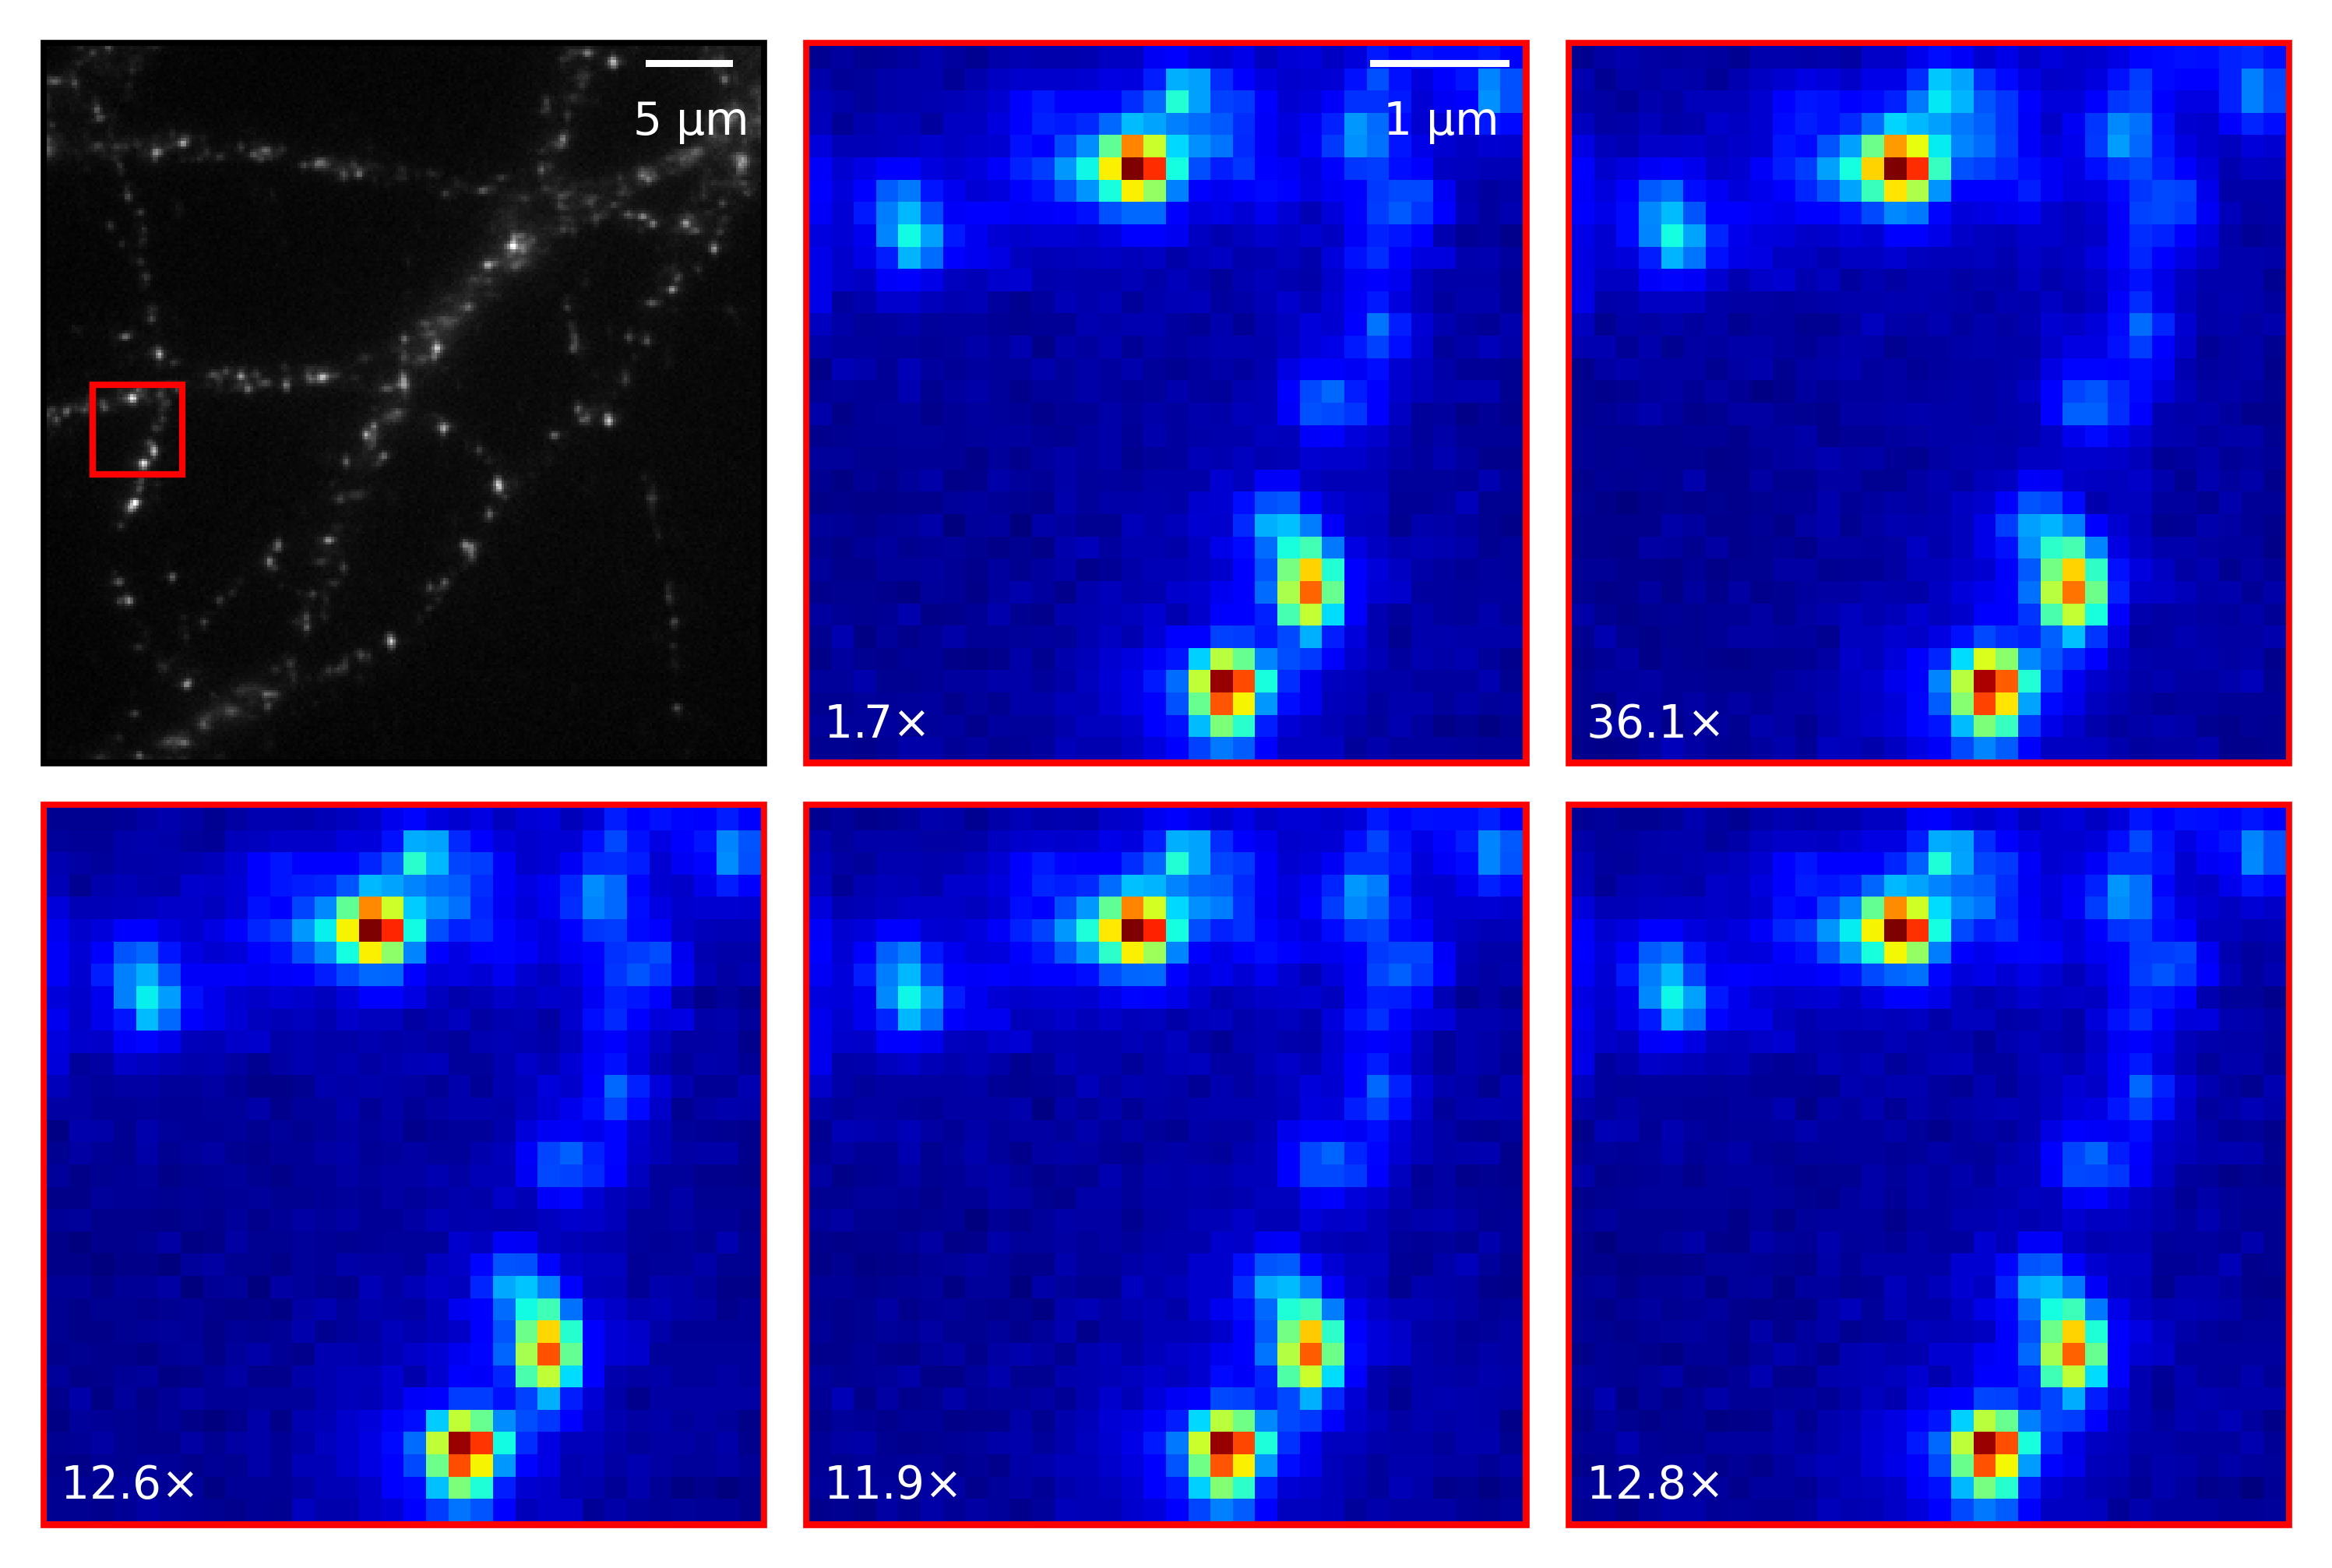

In [28]:
fig, axs = plt.subplots(figsize=(5, 3.4), dpi=600, ncols=3, nrows=2, layout='tight')

axs = axs.flat    

img = imread('/data/duanb/STORM/Aquired STORM.tif')
img = img[0, ...]
img = img * 1.0 / img.max()
img = np.power(img, 0.8)
axs[0].imshow(img, cmap='gray')
axs[1].imshow(imread('compression_big/thumbnail/STORM_patch.tif'), cmap='jet')
axs[2].imshow(imread('compression_big/thumbnail/STORM_AV1_grain_low.tif'), cmap='jet')
axs[3].imshow(imread('compression_big/thumbnail/STORM_X264_low.tif'), cmap='jet')
axs[4].imshow(imread('compression_big/thumbnail/STORM_X265_low.tif'), cmap='jet')
axs[5].imshow(imread('compression_big/thumbnail/STORM_AV1_low.tif'), cmap='jet')

for i in range(0, 6):
    ax = axs[i]
    if i == 0:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('k')
    else:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('r')
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

for i, ratio in zip(range(1, 6), [1.7, 36.1, 12.6, 11.9, 12.8]):
    ax = axs[i]
    at = AnchoredText(f'{ratio:.1f}$\\times$', borderpad=0.2, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
    ax.add_artist(at)

axs[0].add_artist(ScaleBar(160 , 'nm', location='upper right', frameon=False, color='w'))
axs[0].add_patch(patches.Rectangle((16, 121), 32, 32, linewidth=1, edgecolor='r', facecolor='none'))
axs[1].add_artist(ScaleBar(160 , 'nm', location='upper right', frameon=False, color='w'))
plt.savefig('benchmark_part3.pdf', bbox_inches='tight')

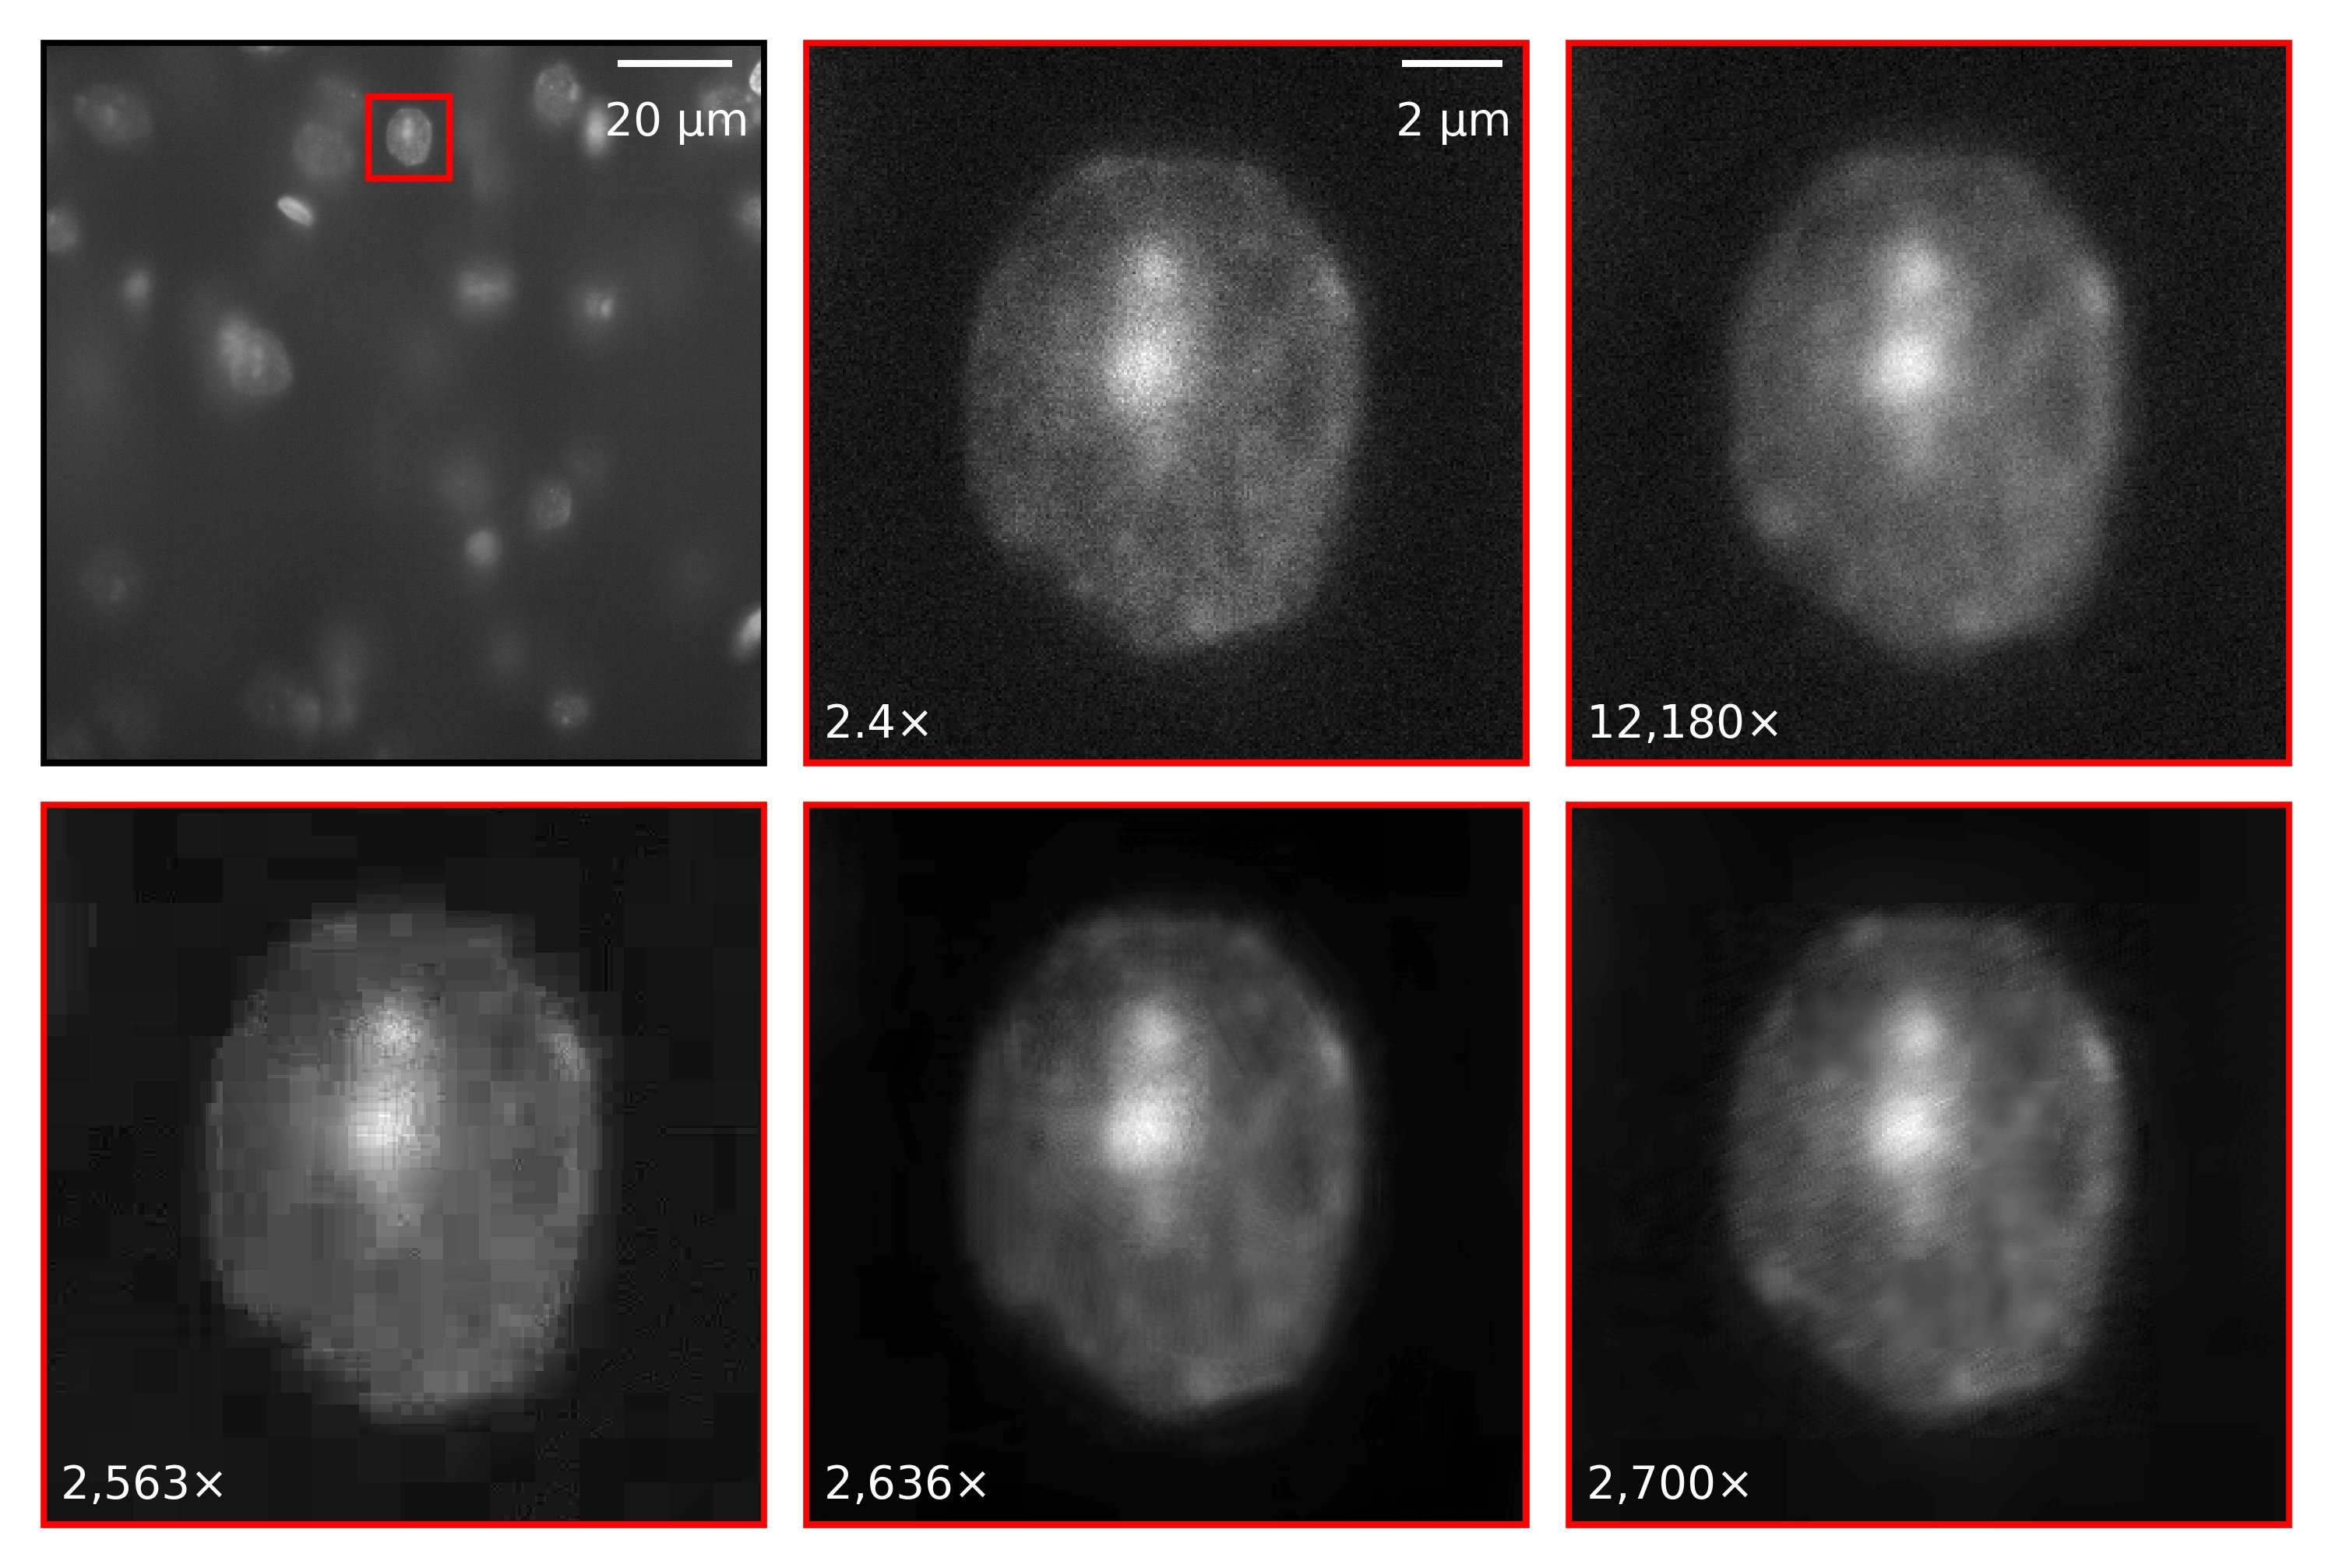

In [12]:
fig, axs = plt.subplots(figsize=(5, 3.4), dpi=600, ncols=3, nrows=2, layout='tight')

axs = axs.flat    

img = imread('/data/duanb/DRAQ5/coord_-5.4,+18.6_2_1X.tif')
img = img[197, ...]
img = img * 1.0 / img.max()
img = np.power(img, 0.1)
axs[0].imshow(img, cmap='gray')
axs[1].imshow(imread('compression_big/thumbnail/DRAQ5_patch.tif'), cmap='gray')
axs[2].imshow(imread('compression_big/thumbnail/DRAQ5_with_filmgrain_12180.tif'), cmap='gray')
axs[3].imshow(imread('compression_big/thumbnail/DRAQ5_X264_2563.tif'), cmap='gray')
axs[4].imshow(imread('compression_big/thumbnail/DRAQ5_X265_2636.tif'), cmap='gray')
axs[5].imshow(imread('compression_big/thumbnail/DRAQ5_no_filmgrain_2700.tif'), cmap='gray')

for i in range(0, 6):
    ax = axs[i]
    if i == 0:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('k')
    else:
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('r')
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

for i, ratio in zip(range(1, 6), [2.4, '12,180', '2,563', '2,636', '2,700']):
    ax = axs[i]
    at = AnchoredText(f'{ratio}$\\times$', borderpad=0.2, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
    ax.add_artist(at)

axs[0].add_artist(ScaleBar(100/1.8, 'nm', location='upper right', frameon=False, color='w'))
axs[0].add_patch(patches.Rectangle((1009, 158), 256, 256, linewidth=1, edgecolor='r', facecolor='none'))
axs[1].add_artist(ScaleBar(100/1.8, 'nm', location='upper right', frameon=False, color='w'))
plt.savefig('benchmark_part4.pdf', bbox_inches='tight')